## ThinkDSP

This notebook contains code examples from Chapter 4: Noise

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

----

- 噪声：一个包含很多频率的信号（它的谐波结构相比周期信号的复杂很多）
- 一类重要的噪声：$P = K / f^\beta$
  - **白噪**：$\beta = 0$（或UncorrelatedGaussianNoise），能量均匀分散在各个频率上（就像白光是所有可见光的均匀混合）。通过`np.random.uniform()`可产生
  - **红噪（Brownian噪声）**：$\beta = 2$，能量多集中在低频部分（红光部分）。通过`np.random.uniform()`产生步长再`np.cumsum()`累加前缀和可产生
  - **粉噪**：$\beta \in (0, 2)$。通过产生白噪声再应用带有目标指数$\beta$的低通滤波器（即直接对频谱作乘运算，`denom = self.fs ** (beta/2.0); denom[0] = 1; self.hs /= denom;`）可产生

- 根据中心极限定律，任何UU-Noise产生的Wave的频谱大体上是服从高斯分布的（假设噪声分布的均值和标准差有限，Wave中包含的样本数量够大，且Wave是经过标准化处理的波形）


In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

In [3]:
np.random.seed(17)

The simplest noise to generate is uncorrelated uniform (UU) noise:

In [4]:
from thinkdsp import UncorrelatedUniformNoise

signal = UncorrelatedUniformNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

Here's what a segment of it looks like:

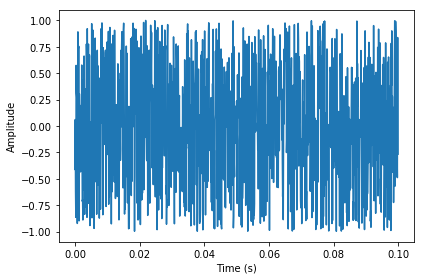

In [5]:
segment = wave.segment(duration=0.1)
segment.plot()
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

And here's the spectrum:

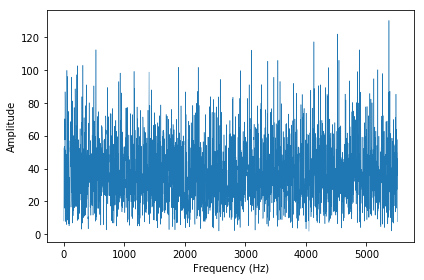

In [6]:
spectrum = wave.make_spectrum()
spectrum.plot(linewidth=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

In the context of noise it is more conventional to look at the spectrum of power, which is the **square of amplitude**:

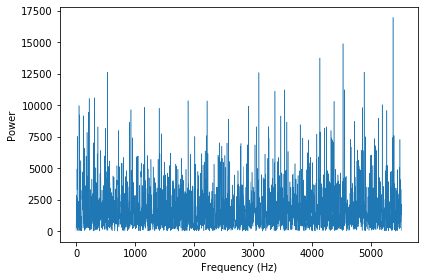

In [7]:
spectrum.plot_power(linewidth=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

UU noise has the same power at all frequencies, on average, which we can confirm by looking at the normalized cumulative sum of power, which I call an integrated spectrum:

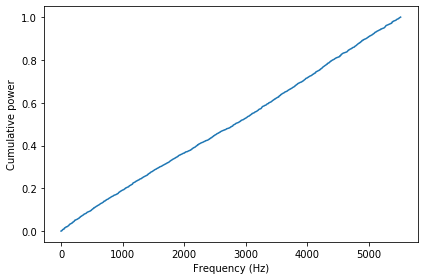

In [8]:
integ = spectrum.make_integrated_spectrum()
integ.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Cumulative power')

A straight line in this figure indicates that **UU noise has equal power at all frequencies, on average.  By analogy with light, noise with this property is called "white noise".**

### Brownian noise

Brownian noise is generated by adding up a sequence of random steps.

In [7]:
from thinkdsp import BrownianNoise

signal = BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

The sound is less bright, or more muffled, than white noise.

Here's what the wave looks like:

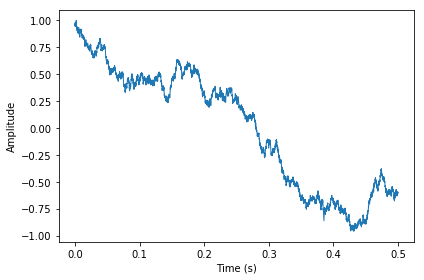

In [8]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

Here's what the power spectrum looks like on a linear scale.

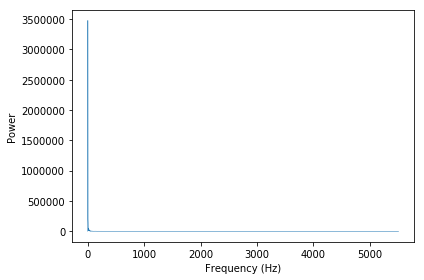

In [9]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

**So much of the energy is at low frequencies, we can't even see the high frequencies.**

We can get a better view by plotting the power spectrum on a log-log scale.

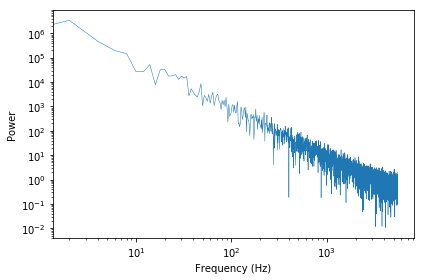

In [10]:
# The f=0 component is very small, so on a log scale
# it's very negative.  If we clobber it before plotting,
# we can see the rest of the spectrum more clearly.
spectrum.hs[0] = 0

spectrum.plot_power(linewidth=0.5)

loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Now the relationship between power and frequency is clearer.  The slope of this line is approximately -2, which indicates **that $P = K / f^2$, for some constant $K$.**

In [13]:
signal =  BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
spectrum = wave.make_spectrum()
result = spectrum.estimate_slope()
result.slope

-1.7846032211221763

The estimated slope of the line is closer to -1.8 than -2, for reasons we'll see later.

### Pink noise

Pink noise is characterized by a parameter, $\beta$, usually between 0 and 2.  You can hear the differences below.

With $\beta=0$, we get white noise:

In [11]:
from thinkdsp import PinkNoise

signal = PinkNoise(beta=0)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

With $\beta=1$, pink noise has the relationship $P = K / f$, which is why it is also called $1/f$ noise.

In [12]:
signal = PinkNoise(beta=1)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

With $\beta=2$, we get Brownian (aka red) noise.

In [13]:
signal = PinkNoise(beta=2)
wave = signal.make_wave(duration=0.5)
wave.make_audio()

The following figure shows the power spectrums for white, pink, and red noise on a log-log scale.

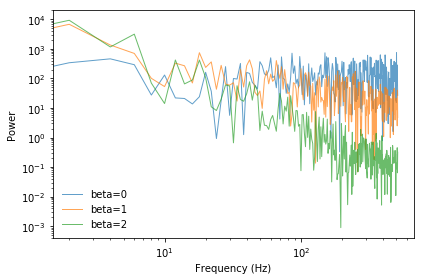

In [14]:
betas = [0, 1, 2]

for beta in betas:
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=0.5, framerate=1024)
    spectrum = wave.make_spectrum()
    spectrum.hs[0] = 0
    label = f'beta={beta}'
    spectrum.plot_power(linewidth=1, alpha=0.7, label=label)
    
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

### Uncorrelated Gaussian noise

An alternative to UU noise is uncorrelated Gaussian (UG noise).

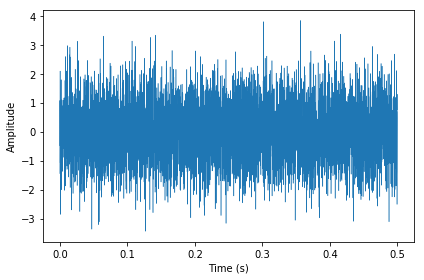

In [15]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.plot(linewidth=0.5)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

The spectrum of UG noise is also UG noise.

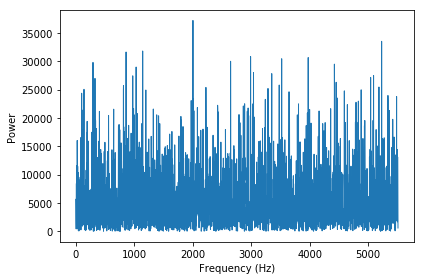

In [16]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=1)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

We can use a normal probability plot to test the distribution of the power spectrum.

In [20]:
def normal_prob_plot(sample, fit_color='0.8', **options):
    """Makes a normal probability plot with a fitted line.

    sample: sequence of numbers
    fit_color: color string for the fitted line
    options: passed along to Plot
    """
    n = len(sample)
    xs = np.random.normal(0, 1, n)
    xs.sort()
    
    ys = np.sort(sample)
    
    mean, std = np.mean(sample), np.std(sample)
    fit_ys = mean + std * xs
    plt.plot(xs, fit_ys, color='gray', alpha=0.5, label='model')

    plt.plot(xs, ys, **options)

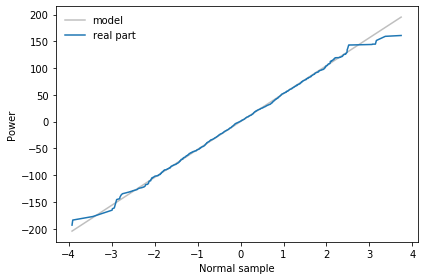

In [21]:
normal_prob_plot(spectrum.real, color='C0', label='real part')
decorate(xlabel='Normal sample',
         ylabel='Power')

A straight line on a normal probability plot indicates that the distribution of the real part of the spectrum is Gaussian.

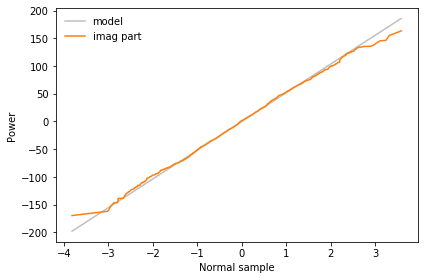

In [22]:
normal_prob_plot(spectrum.imag, color='C1', label='imag part')
decorate(xlabel='Normal sample',
         ylabel='Power')

And so is the imaginary part.